# Validación de cálculos de verosimilitud con **Familias**

Se validan los cálculos obtenidos con la red bayesiana con los del software **Familias** (https://familias.no/)

Los datos corresponden a 2000 simulaciones para un caso de paternidad.

In [1]:
from modulos.analisis_pedigri import *

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from numpy import random
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

## Definición de pedigríes

Las hipótesis que se contrastan son dos.

La validación consite en calcular las verosimilitudes y ver si se obtiene lo mismo usando familias.

Las simulaciones son de dos tipos:

1. H1 es verdadera

2. H2 es verdadera

Son 1000 de cada tipo

### H1: El presunto es el padre biologico del niño

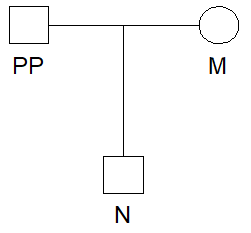

In [4]:
Image(filename='figuras/fig_paternidad_simple_h1.png')

### H2: Un hombre al azar en la población es el padre del niño y el presunto padre no tiene relación con él

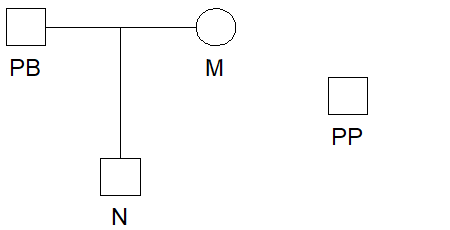

In [5]:
Image(filename='figuras/fig_paternidad_simple_h2_completa.png')

## Parámetros de la simulación

Las simulaciones se generaron con Familias con los parámetros de la figura que se muestra a continuación.

Se usó un solo locus con 5 alelos

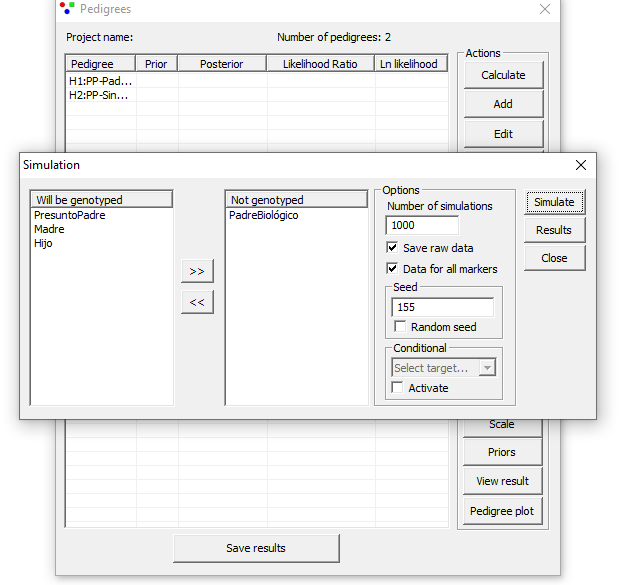

In [6]:
Image(filename='figuras/parámetros_simulaciones.png')

In [7]:
n_alelos = 5

In [8]:
frecuencias_alelos = np.array([0.1 , 0.14, 0.24, 0.04, 0.48])

In [9]:
frecuencias_alelos.sum()

1.0

In [10]:
alelos = ['a_1', 'a_2', 'a_3', 'a_4', 'a_5']

## Lectura y preparación de datos

Se lee el resultado de 1000 simulaciones de los pedigríes estudiados.

In [11]:
simulacion_path = r'datos\simulaciones_familias\simulaciones_paternidad_1000_seed_155_PV_no_genotipo.txt'
df_simulacion_ = pd.read_csv(simulacion_path, sep = '\t', skiprows = [0,1])
df_simulacion_ = df_simulacion_.drop(columns = 'Unnamed: 14')

### Formato de salida de Familias

Hay que procesarlo para quedarse únicamente con los alelos

De este dataframe aún se van a consultar los valores de la verosimilitud, que se reportan en logaritmos

In [12]:
df_simulacion_.head()

,#Simulation,Marker,TRUE PED,logLikelihod(H1:PP-PadreVerdadero),logLikelihod(H2:PP-SinRelacion),PresuntoPadre,Allele 1,Allele2,Madre,Allele 1.1,Allele2.1,Hijo,Allele 1.2,Allele2.2
0,1,marcador1,H1:PP-PadreVerdadero,-4.16802,-5.44099,NaN,a_5,a_2,NaN,a_5,a_5,NaN,a_2,a_5
1,1,marcador1,H2:PP-SinRelacion,-4.86117,-5.59514,NaN,a_3,a_5,NaN,a_5,a_2,NaN,a_3,a_5
2,2,marcador1,H1:PP-PadreVerdadero,-4.32217,-4.36299,NaN,a_5,a_3,NaN,a_5,a_3,NaN,a_5,a_5
3,2,marcador1,H2:PP-SinRelacion,NaN,-5.59514,NaN,a_5,a_5,NaN,a_5,a_3,NaN,a_2,a_5
4,3,marcador1,H1:PP-PadreVerdadero,-3.62902,-3.95753,NaN,a_3,a_5,NaN,a_3,a_5,NaN,a_3,a_5


In [13]:
nombres_personas = ['PresuntoPadre', 'Madre', 'Hijo']

def construir_observaciones_fila(row):
    df_observaciones = pd.DataFrame(index = nombres_personas, columns = ['alelo_1', 'alelo_2'])
    for nombre_p in nombres_personas:
        ix_col = df_simulacion_.columns.get_loc(nombre_p)
        alelo1 = row[ix_col+1]
        alelo2 = row[ix_col+2]
        df_observaciones.loc[nombre_p, 'alelo_1'] = alelo1
        df_observaciones.loc[nombre_p, 'alelo_2'] = alelo2
    return df_observaciones
lista_df_simulaciones = df_simulacion_.apply(construir_observaciones_fila, axis = 1)

In [14]:
lista_columnas = []
for nombre_p in nombres_personas:
    ix_col = df_simulacion_.columns.get_loc(nombre_p)
    ix_col
    p_alelo1 = df_simulacion_.iloc[:,ix_col+1].rename(nombre_p + '_1')
    p_alelo2 = df_simulacion_.iloc[:,ix_col+2].rename(nombre_p + '_0')
    lista_columnas.append(p_alelo1)
    lista_columnas.append(p_alelo2)
df_simulacion = pd.concat(lista_columnas, axis = 1)

### Datos preparados

Los renglones corresponden a simulaciones

In [15]:
df_simulacion.head(5)

,PresuntoPadre_1,PresuntoPadre_0,Madre_1,Madre_0,Hijo_1,Hijo_0
0,a_5,a_2,a_5,a_5,a_2,a_5
1,a_3,a_5,a_5,a_2,a_3,a_5
2,a_5,a_3,a_5,a_3,a_5,a_5
3,a_5,a_5,a_5,a_3,a_2,a_5
4,a_3,a_5,a_3,a_5,a_3,a_5


### Frecuencias de los alelos usadas vs observadas

In [16]:
conteo_alelos = df_simulacion.apply(lambda x:x.value_counts()).sum(axis = 1)
frecuencias_observadas = conteo_alelos/conteo_alelos.sum()
frecuencias_observadas = frecuencias_observadas[alelos]

Las frecuencias observadas corresponden con las definidas para la simulación

In [17]:
pd.DataFrame({'frecuencia_real':frecuencias_alelos, 'frecuencia_observada':frecuencias_observadas}).round(2)

,frecuencia_real,frecuencia_observada
a_1,0.10,0.10
a_2,0.14,0.13
a_3,0.24,0.23
a_4,0.04,0.04
a_5,0.48,0.50


## Definición de los datos de los pedigríes

Se definen los miembros, las relaciones que sostienen, y se especifica de qué personas se conoce su genotipo.

Aunque son dos hipótesis, la segunda se subdivide en dos, en la que otro hombre, el padre biológico es el padre del niño y otro pedigrí en el que aparece solo el presunto padre.

La verosimilitud para la hipótesis dos se calcula como un producto de las dos partes.

#### Pedigrí 1

In [18]:
fundadores_1 = ['PresuntoPadre', 'Madre']
descendientes_1 = ['Hijo']
dict_relaciones_persona_padres_1 = {'Hijo':('PresuntoPadre','Madre')}
personas_observadas_1 = ['PresuntoPadre', 'Madre', 'Hijo']
personas_no_observadas_1 = []

#### Pedigrí 2_1

In [19]:
fundadores_2_1 = ['PadreBiológico', 'Madre']
descendientes_2_1 = ['Hijo']
dict_relaciones_persona_padres_2_1 = {'Hijo':('PadreBiológico','Madre')}
personas_observadas_2_1 = ['Madre', 'Hijo']
personas_no_observadas_2_1 = ['PadreBiológico']

#### Pedigrí 2_2

In [20]:
fundadores_2_2 = ['Padre(PP)', 'Madre(PP)']
descendientes_2_2 = ['PresuntoPadre']
dict_relaciones_persona_padres_2_2 = {'PresuntoPadre':('Padre(PP)','Madre(PP)')}
personas_observadas_2_2 = ['PresuntoPadre']
personas_no_observadas_2_2 = ['Padre(PP)', 'Madre(PP)']

## Cálculo de las distribuciones marginales, y de verosimilitudes para un ejemplo.

Con este ejemplo se muestra cómo hacer los cálculos, para luego automatizar el cálculo del resto de las simulaciones

Las distribuciones marginales servirán para evaluar todas las simulaciones de forma eficiente.

Esta función es últil porque una vez que se calculan las distribuciones marginales se pueden usar para evaluar todas las simulaciones

In [21]:
def calcular_verosimilitud_con_marginal(df_genotipos_observados, distribucion_marginal, alelos):
    # se obtienen los genotipos ordenados
    df_genotipos_ordenados = enlistar_genotipos_ordenados(df_genotipos_observados, df_genotipos_observados.index)
    
    # se evalua la marginal en cada uno de los genotipos ordenados y se regresa la suma
    probabilidades_genotipos = df_genotipos_ordenados.apply(lambda alelos_ordenados: evaluar_marginal_pedigri(distribucion_marginal, alelos_ordenados = alelos_ordenados, nombres_alelos = alelos))
    verosimilitud = probabilidades_genotipos.sum()
    return verosimilitud

### Genotipos observados en cada pedigrí

In [22]:
ix_simulacion = 0
df_genotipos_observados = lista_df_simulaciones[ix_simulacion]

Los datos observados son distintos en cada pedigrí

In [23]:
df_genotipos_observados_1 = df_genotipos_observados.copy()
df_genotipos_observados_1

,alelo_1,alelo_2
PresuntoPadre,a_5,a_2
Madre,a_5,a_5
Hijo,a_2,a_5


In [24]:
df_genotipos_observados_2_1 = df_genotipos_observados.loc[['Madre','Hijo']].copy()
df_genotipos_observados_2_1

,alelo_1,alelo_2
Madre,a_5,a_5
Hijo,a_2,a_5


In [25]:
df_genotipos_observados_2_2 = df_genotipos_observados.loc[['PresuntoPadre']].copy()
df_genotipos_observados_2_2

,alelo_1,alelo_2
PresuntoPadre,a_5,a_2


### Cálculo de marginales y verosimilitudes

#### Pedigrí 1. H1: El supuesto padre es el padre verdadero

In [26]:
# se obtiene la distribución marginal   
distribucion_marginal_1 = distribucion_marginal_pedigri(fundadores_1, descendientes_1,
                                                      dict_relaciones_persona_padres_1,
                                                      personas_observadas_1, personas_no_observadas_1,
                                                      alelos, frecuencias_alelos)

In [27]:
verosimilitud_1 = calcular_verosimilitud_con_marginal(df_genotipos_observados_1, distribucion_marginal_1, alelos)

print('verosimilitud:', verosimilitud_1)
print('log(verosimilitud):', np.log(verosimilitud_1))

verosimilitud: 0.015482880000000001
log(verosimilitud): -4.168020381613434


#### Pedigrí 2. H2: El supuesto padre no tiene relación con el niño

Esta hipótesis se puede considerar como compuesta de dos pedigríes, en primer lugar, se sostiene el hecho que la relación Madre-Hijo es verdadera, y por el otro, se afirma que el padre del niño no tiene relación con el supuesto padre y pudo haber sido una persona al *azar* de la población.

#### Pedigrí 2.1 H2_1: Una persona al azar de la población es el padre del niño y la relación Madre-Hijo es verdadera

In [28]:
# se obtiene la distribución marginal   
distribucion_marginal_2_1 = distribucion_marginal_pedigri(fundadores_2_1, descendientes_2_1,
                                                      dict_relaciones_persona_padres_2_1,
                                                      personas_observadas_2_1, personas_no_observadas_2_1,
                                                      alelos, frecuencias_alelos)

In [29]:
verosimilitud_2_1 = calcular_verosimilitud_con_marginal(df_genotipos_observados_2_1, distribucion_marginal_2_1, alelos)

print('verosimilitud:', verosimilitud_2_1)
print('log(verosimilitud):', np.log(verosimilitud_2_1))

verosimilitud: 0.03225600000000001
log(verosimilitud): -3.4340512065332334


#### Pedigrí 2.2 H2_2: El supuesto padre no tiene relación con el niño

In [30]:
# se obtiene la distribución marginal   
distribucion_marginal_2_2 = distribucion_marginal_pedigri(fundadores_2_2, descendientes_2_2,
                                                      dict_relaciones_persona_padres_2_2,
                                                      personas_observadas_2_2, personas_no_observadas_2_2,
                                                      alelos, frecuencias_alelos)

In [31]:
verosimilitud_2_2 = calcular_verosimilitud_con_marginal(df_genotipos_observados_2_2, distribucion_marginal_2_2, alelos)

print('verosimilitud:', verosimilitud_2_2)
print('log(verosimilitud):', np.log(verosimilitud_2_2))

verosimilitud: 0.13440000000000002
log(verosimilitud): -2.0069348508930878


In [32]:
verosimilitud_2 = verosimilitud_2_1 * verosimilitud_2_2
print("verosimilitud:", verosimilitud_2)
print("log(verosimilitud):", np.log(verosimilitud_2))

verosimilitud: 0.004335206400000001
log(verosimilitud): -5.440986057426321


### Resumen

#### Datos de la simulación (Familias)

In [33]:
df_simulacion_.iloc[0,1:5]

Marker                                           marcador1
TRUE PED                              H1:PP-PadreVerdadero
logLikelihod(H1:PP-PadreVerdadero)                -4.16802
logLikelihod(H2:PP-SinRelacion)                   -5.44099
Name: 0, dtype: object

#### Cálculos con la red bayesiana

##### Hipótesis 1: El supuesto padre es el verdadero padre del niño

In [34]:
print("verosimilitud L1 : P(datos|H1) = ", verosimilitud_1)
print("log(verosimilitud) L1 : P(datos|H1) = ", round(np.log(verosimilitud_1),5))

verosimilitud L1 : P(datos|H1) =  0.015482880000000001
log(verosimilitud) L1 : P(datos|H1) =  -4.16802


##### Hipótesis 2: Un hombre al azar es el padre del niño

In [35]:
print("verosimilitud L2 : P(datos|H2) = ", verosimilitud_2)
print("log(verosimilitud) L2 : P(datos|H2) = ", round(np.log(verosimilitud_2),5))

verosimilitud L2 : P(datos|H2) =  0.004335206400000001
log(verosimilitud) L2 : P(datos|H2) =  -5.44099


## Cálculos para el resto de simulaciones

#### Función para evaluar un renglón del conjunto de simulaciones

In [36]:
def evalua_simulacion(ix_simulacion, verbose = False):
    
    df_genotipos_observados = lista_df_simulaciones[ix_simulacion]

    df_genotipos_observados_1 = df_genotipos_observados.copy()
    df_genotipos_observados_2_1 = df_genotipos_observados.loc[['Madre','Hijo']].copy()
    df_genotipos_observados_2_2 = df_genotipos_observados.loc[['PresuntoPadre']].copy()

    #verosimilitud 1
    verosimilitud_1 = calcular_verosimilitud_con_marginal(df_genotipos_observados_1, distribucion_marginal_1, alelos)
    #verosimilitud 2_1
    verosimilitud_2_1 = calcular_verosimilitud_con_marginal(df_genotipos_observados_2_1, distribucion_marginal_2_1, alelos)
    #verosimilitud 2_2
    verosimilitud_2_2 = calcular_verosimilitud_con_marginal(df_genotipos_observados_2_2, distribucion_marginal_2_2, alelos)
    
    verosimilitud_2 = verosimilitud_2_1 * verosimilitud_2_2
    
    if verbose:
        print("Red Bayesiana:")
        print("verosimilitud L1 : P(datos|H1) = ", verosimilitud_1)
        print("verosimilitud L2 : P(datos|H2) = ", verosimilitud_2)
        print("log(verosimilitud) L1 : P(datos|H1) = ", round(np.log(verosimilitud_1),5))
        print("log(verosimilitud) L2 : P(datos|H2) = ", round(np.log(verosimilitud_2),5))
        print("\nFamilias:\n",df_simulacion_.iloc[ix_simulacion,0],df_simulacion_.iloc[ix_simulacion,2:5])
        if(verosimilitud_2 != 0):
            print("\nCociente verosimilitudes L1/L2 : P(datos|H1)/P(datos|H2) = ", verosimilitud_1/verosimilitud_2)
        print("\nGenotipos:\n",lista_df_simulaciones[ix_simulacion])

    resumen_sim = pd.Series([verosimilitud_1, np.log(verosimilitud_1), verosimilitud_2, np.log(verosimilitud_2)], 
              index = ['Verosimilitud_L1', 'logVerosimilitud_L1', 'Verosimilitud_L2', 'logVerosimilitud_L2'],
             name = 'resumen_simulacion')
    resumen_sim_combinado =  pd.concat([resumen_sim, df_simulacion_.iloc[ix_simulacion,2:5]])
    return resumen_sim_combinado

### Ejemplos

#### Un caso en el que H1 es verdadera

In [37]:
ix_simulacion = 0
res_sim_ix = evalua_simulacion(ix_simulacion, verbose = True)

Red Bayesiana:
verosimilitud L1 : P(datos|H1) =  0.015482880000000001
verosimilitud L2 : P(datos|H2) =  0.004335206400000001
log(verosimilitud) L1 : P(datos|H1) =  -4.16802
log(verosimilitud) L2 : P(datos|H2) =  -5.44099

Familias:
 1 TRUE PED                              H1:PP-PadreVerdadero
logLikelihod(H1:PP-PadreVerdadero)                -4.16802
logLikelihod(H2:PP-SinRelacion)                   -5.44099
Name: 0, dtype: object

Cociente verosimilitudes L1/L2 : P(datos|H1)/P(datos|H2) =  3.5714285714285707

Genotipos:
               alelo_1 alelo_2
PresuntoPadre     a_5     a_2
Madre             a_5     a_5
Hijo              a_2     a_5


#### Un caso en el que H2 es verdadera

In [38]:
ix_simulacion = 1
res_sim_ix = evalua_simulacion(ix_simulacion, verbose = True)

Red Bayesiana:
verosimilitud L1 : P(datos|H1) =  0.0077414400000000005
verosimilitud L2 : P(datos|H2) =  0.0037158912000000007
log(verosimilitud) L1 : P(datos|H1) =  -4.86117
log(verosimilitud) L2 : P(datos|H2) =  -5.59514

Familias:
 1 TRUE PED                              H2:PP-SinRelacion
logLikelihod(H1:PP-PadreVerdadero)             -4.86117
logLikelihod(H2:PP-SinRelacion)                -5.59514
Name: 1, dtype: object

Cociente verosimilitudes L1/L2 : P(datos|H1)/P(datos|H2) =  2.083333333333333

Genotipos:
               alelo_1 alelo_2
PresuntoPadre     a_3     a_5
Madre             a_5     a_2
Hijo              a_3     a_5


### Cálculos en todo las simulaciones

#### Cálculos y escritura de resultados

Requiere algunos minutos, se calcula sólo una vez y después se guarda en disco para retomar el análisis cuando se requiera sin tener que repetir los cálculos. Quitar los símbolos de comentario para volver a calcular.

In [39]:
#lista_resultados = [evalua_simulacion(ix) for ix in range(len(lista_df_simulaciones))]
#df_resultados = pd.concat(lista_resultados, axis = 1).T
#df_resultados.to_csv('datos/salida/resultados_simulaciones_paternidad_1000_seed_155_PV_no_genotipo.csv', index = False, encoding = 'utf-8-sig')

#### Lectura de resultados

In [40]:
df_resultados = pd.read_csv(r'datos/salida/resultados_simulaciones_paternidad_1000_seed_155_PV_no_genotipo.csv', encoding = 'utf-8-sig')

In [41]:
df_resultados['LR_12'] = df_resultados['Verosimilitud_L1']/df_resultados['Verosimilitud_L2']

### Análisis de los resultados

#### Estructura

In [42]:
df_resultados.head()

,Verosimilitud_L1,logVerosimilitud_L1,Verosimilitud_L2,logVerosimilitud_L2,TRUE PED,logLikelihod(H1:PP-PadreVerdadero),logLikelihod(H2:PP-SinRelacion),LR_12
0,0.015483,-4.168020,0.004335,-5.440986,H1:PP-PadreVerdadero,-4.16802,-5.44099,3.571429
1,0.007741,-4.861168,0.003716,-5.595137,H2:PP-SinRelacion,-4.86117,-5.59514,2.083333
2,0.013271,-4.322171,0.012740,-4.362993,H1:PP-PadreVerdadero,-4.32217,-4.36299,1.041667
3,0.000000,-inf,0.003716,-5.595137,H2:PP-SinRelacion,NaN,-5.59514,0.000000
4,0.026542,-3.629024,0.019110,-3.957528,H1:PP-PadreVerdadero,-3.62902,-3.95753,1.388889


#### Resumen de valores de LR = P(datos|H1)/P(datos|H2)

Los resultados obtenidos son idénticos a los que se obtienen con **Familias**.

Los cálculos se agrupan de acuerdo a la hipótesis que es verdadera *'TRUE PED'*

In [43]:
df_resumen_simulacion = pd.DataFrame(columns = ['Mediana', 'Media', '95%', '5%', 'Stdev'])
for name, group in df_resultados.groupby('TRUE PED'):
    g_lr = group['LR_12']
    df_resumen_simulacion.loc[name] = [g_lr.median(), g_lr.mean(),g_lr.quantile(q = .95), g_lr.quantile(q = .05),  g_lr.std()]

In [44]:
df_resumen_simulacion.round(3)

,Mediana,Media,95%,5%,Stdev
H1:PP-PadreVerdadero,2.083,2.814,7.286,0.862,2.586
H2:PP-SinRelacion,1.042,1.097,3.571,0.000,1.352


#### Comparación con Familias

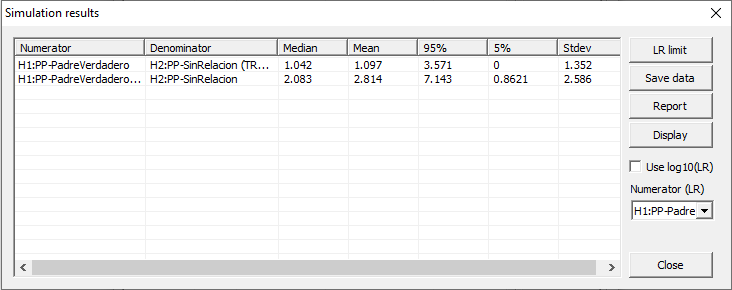

In [45]:
Image(filename='figuras/f_simulaciones_paternidad_cut.png')

#### Comparación de los cálculos entrada a entrada

Se calculan la suma y la media de las diferencias

##### H1

log(verosimilitud)

In [46]:
((df_resultados['logVerosimilitud_L1'] - df_resultados['logLikelihod(H1:PP-PadreVerdadero)'])** 2).sum()

1.3072959244435268e-08

In [47]:
((df_resultados['logVerosimilitud_L1'] - df_resultados['logLikelihod(H1:PP-PadreVerdadero)'])** 2).mean()

8.180825559721756e-12

verosimilitud

In [48]:
((df_resultados['Verosimilitud_L1'] - np.exp(df_resultados['logLikelihod(H1:PP-PadreVerdadero)']))** 2).sum()

5.428364948230087e-12

In [49]:
((df_resultados['Verosimilitud_L1'] - np.exp(df_resultados['logLikelihod(H1:PP-PadreVerdadero)']))** 2).mean()

3.3969743105319696e-15

##### H2

log(verosimilitud)

In [50]:
((df_resultados['logVerosimilitud_L2'] - df_resultados['logLikelihod(H2:PP-SinRelacion)'])** 2).sum()

3.8263431519645957e-08

In [51]:
((df_resultados['logVerosimilitud_L2'] - df_resultados['logLikelihod(H2:PP-SinRelacion)'])** 2).mean()

1.9131715759823015e-11

verosimilitud

In [52]:
((df_resultados['Verosimilitud_L2'] - np.exp(df_resultados['logLikelihod(H2:PP-SinRelacion)']))** 2).sum()

2.1231930912455523e-12

In [53]:
((df_resultados['Verosimilitud_L2'] - np.exp(df_resultados['logLikelihod(H2:PP-SinRelacion)']))** 2).mean()

1.0615965456227698e-15